# Homework 2

This homework will have a mix of theory questions and coding questions defined throughout the notebook. Please turn the theory questions in at class on Friday, Sept. 20, and upload the notebook to canvas.

In [3]:
# This is code for loading the libraries needed for the assignment
import numpy as np
from casadi import *
import scipy.linalg as la
import matplotlib.pyplot as plt
import minecraftControl as mc

env = mc.constrainedBall()

%matplotlib inline

# Constrained Sphere Gym Environment

The rolling sphere problem from last week has been modified to be compatible with OpenAI Gym, a popular testbed for reinforcement learning. This is so that our codes for the class can be streamlined for compatibility. 

This problem is similar to the system we used last week, except now constraints on the state and input are enforced.

An example of its use, with randomly generated inputs is given below.

[ 1.87132671 -0.5534504   0.          0.        ]
{'StateFeasible': False, 'InputFeasible': True}
u: [-0.35646626 -0.763947  ]
x: [ 1.88545786  2.53696317 -0.09000487  0.34528444]


Text(0, 0.5, 'u')

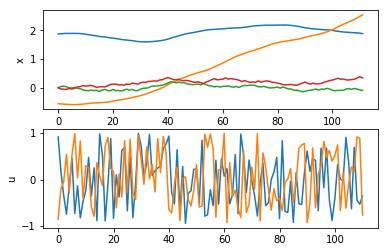

In [4]:
# We need to first call reset to initialize the state
x = env.reset()
print(x)
X_traj = [x]
U_traj = []


for _ in range(1000):
    # Randomly generate a feasible input
    u = env.action_space.sample()
    x,r,done,info = env.step(u)
    
    # Saving the state and action sequences
    X_traj.append(x)
    U_traj.append(u)
    
    # Render shows the video
    # If you don't want video, comment the line out.
    env.render()
    if done:
        # This stops the simulation when 
        # a constraint is violated
        print(info)
        print('u:',u)
        print('x:',x)
        break
    
env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
U_traj = np.array(U_traj)
fig,ax = plt.subplots(2,1)
ax[0].plot(X_traj)
ax[0].set_ylabel('x')
ax[1].plot(U_traj)
ax[1].set_ylabel('u')

In [5]:
# The constraints are shown here
print('x - lower bound:',env.observation_space.low)
print('x - upper bound:',env.observation_space.high)
print('u - lower bound:',env.action_space.low)
print('u - upper bound:',env.action_space.high)
print(type(env.observation_space.low))
print(env.observation_space.low.shape)

x - lower bound: [-2.5 -2.5 -0.4 -0.4]
x - upper bound: [2.5 2.5 0.4 0.4]
u - lower bound: [-1. -1.]
u - upper bound: [1. 1.]
<class 'numpy.ndarray'>
(4,)


This homework will step through the procedure of building an MPC controller for this system 

The dynamics of the system are given by
$$
x^+ = Ax + Bu
$$
where $A$ and $B$ are the matrices defined below.

In [6]:
dt = env.dt
A = np.array([[1,0,3 *dt,0],
              [0,1,0,3 * dt],
              [0,0,1,0],
              [0,0,0,1]])

B = np.array([[0,0],
              [0,0],
              [dt,0],
              [0,dt]])

# Theory Question 1 



Recall that the infitinite-horizon regulator solution for step cost $x^\top Q x + u^\top R u$
is given by $u= Kx$ where $K$ is defined by:
\begin{align*}
S&= Q + A^\top S A - A^\top S B(R+B^\top S B)^{-1} B^\top S A \\
K&= -(R+B^\top S B)^{-1} B^\top S A
\end{align*}

Assume that $S$ is positive definite and the origin is asymptoically stable for the system $x^+=(A+BK)x$.
Show that $V(x) = x^\top S x$ is a Lyapunov function for this system. 

Furthermore,  show that if $x(k+1) = (A+BK)x(k)$ and $\ell(x,u) = x^\top Q x + u^\top R u$,  then
\begin{equation*}
x(0)^\top S x(0) = \sum_{k=0}^{\infty} \ell(x(k),u(k))
\end{equation*}

# Coding Question 1

Let $Q$ be and $R$ be identity matrices of appropriate size. Use the command `la.solve_discrete_are` to find $S$, and then compute $K$ for this system.

In [7]:
# Define your solution here
Q = np.eye(4)
R = np.eye(2)
S = la.solve_discrete_are(A, B, Q, R)
K = -la.inv(R + B.T @ S @ B) @ B.T @ S @ A
# Change these to the correct values
print(S)
print(K)

[[18.65488318  0.         21.36790041  0.        ]
 [ 0.         18.65488318  0.         21.36790041]
 [21.36790041  0.         56.58716782  0.        ]
 [ 0.         21.36790041  0.         56.58716782]]
[[-0.9359834   0.         -2.61909914  0.        ]
 [ 0.         -0.9359834   0.         -2.61909914]]


# Theory Question 2

One of the fundamental conditions required to ensure stability of MPC is that the final constraint set $\mathbb{X}_f$ and the final cost $V_f$ be such that for all $x\in \mathbb{X}_f$, there is a $u$ such
*  $Ax+Bu\in \mathbb{X}_f$ (control invariance)
* $V_f(Ax+Bu) + \ell(x,u) \le V_f(x)$ (non-increasing end cost)
* $(x,u)$ is feasible (control feasibility).

We saw that if the system is linear, and a stabilizing control gain $K$, then the final cost and constraint could be constructed from the corresponding Lyapunov function. Namely, if 
$$
V_f(x) = x^\top Sx,
$$
where $S$ and $K$ are defined as above, and $\mathbb{X}_f = \{x | V_f(x) \le c\}$ for some positive $c$, then the control invariance and non-increasing cost conditions are automatically satisfied by choosing $u=Kx$.

Thus, the only thing that remains is to find $c>0$ such that the feasibility condition holds. Here we will describe a systematic method for finding such a $c$.

The constraints on the control and state were defined above. They can be written in vector form 
$$
Fx + Gu \preceq h,
$$
where the inequality is interpreted elementwise.

Show that $c$ can be found by solving a collection of quadratic programs. (A quadratic program is an optimization problem in which the objective is quadratic and the constraints are affine.)

Explain how the code below implements such a procedure. (Of course, this makes the question easier, but CasADi has substantially less online documentation than other tools used in this class. So seeing how it is used for our problems is helpful.)

In [8]:
# NOTE: This code will only work properly if K is a stabilizing gain and S is the corresponding
# Lyapunov Matrix. In other words, you need to have solved the previous problem.

# Here is CasADi syntax for defining symbolic variables
x_sym = MX.sym('x',4)

u_sym = K @ x_sym

# Unlike numpy, CasADi assumes everything is a matrix
# So, you need to do explicit transposes to represent row vecrors
QuadObj = x_sym.T @ S @ x_sym

# These will represent constraints to be violated
g_u_low = env.action_space.low - u_sym
g_u_high = u_sym - env.action_space.high

g_x_low = env.observation_space.low - x_sym
g_x_high = x_sym - env.observation_space.high

g_vec = vertcat(g_u_low,g_u_high,g_x_low,g_x_high)

c = np.inf
print(g_vec.shape)
for i in range(g_vec.shape[0]):
    qp = {'x' : x_sym,'f' : QuadObj, 'g' : g_vec[i]}

    solver = qpsol('solver','qpoases',qp)
    qp_res = solver(lbg=0)
    print(qp_res['f'])
    c = np.min([qp_res['f'],c])
    
# Just to make it a bit conservative, decrease a bit further
c = .9 * c

print(c)

(12, 1)


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.320755e-09   |   REM BND    3   |     3   |     0   
       1   |   3.252955e-11   |   REM BND    2   |     2   |     0   
       2   |   1.044585e-08   |   REM BND    1   |     1   |     0   
       3   |   5.646548e-11   |   REM BND    0   |     0   |     0   
       4   |   4.123038e-01   |   ADD CON    0   |     0   |     1   
       5   |   1.000000e+00   |    QP SOLVED     |     0   |     1   
8.23121


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.320755e-09   |   REM BND    3   |     3   |     0   
       1   |   3.252955e-11   |   REM BND    2   |     2   |  

# Coding Question 2

Use CasADi to create a nonlinear program for computing an MPC controller using the costs $\ell(x,u) = x^\top x + u^\top u$, and $V_f(x) = x^\top S x$. Because the final cost constraint $V_f(x_N)\le c$ is quadratic, the problem can no longer be cast as quadratic program. So, you'll need to use the CasADi nonlinear programming interface. (The syntax is similar to the quadratic program.)

With $\mathbb{X}_f$ and $c$ defined as above, you'll likely need a horizon of around $N=50$ to ensure that the MPC problem is always feasible. 

Test your controller by simulating 100 steps of the gym environment and plotting the result. (So, just modify the code above.)

Hint: Due to numerical error, your MPC controller may produce inputs that slightly violate the constraints, which will cause the simulation to stop. To get around this, you can "tighten"  the constraints by casting them in the form $Fx + Gx\le h -\epsilon \mathbf{1}$, where $\epsilon $ is a small positive number and $\mathbf{1}$ is the vector of all ones.

[-0.94999999  0.94999998]
[-0.95        0.94999999]
[-0.95        0.94999998]
[-0.94999997  0.94999982]
[-0.94999991  0.89764413]
[-0.93484625  0.72868019]
[-0.67537068  0.57411746]
[-0.43319092  0.43278536]
[-0.20659088  0.30353991]
[-1.57813871e-06  1.85479239e-01]
[8.36832717e-09 7.77530226e-02]
[9.24492617e-09 9.48309072e-07]
[ 1.02507773e-08 -2.95845352e-08]
[ 1.14122110e-08 -3.47294382e-08]
[-1.00504228e-07  2.05097167e-07]
[ 5.20199849e-09 -1.79288871e-08]
[ 1.38599352e-07 -1.97971359e-06]
[ 1.83972604e-08 -3.84500346e-02]
[ 2.10287100e-08 -8.20391243e-02]
[ 2.42051623e-08 -1.19533294e-01]
[ 2.80767060e-08 -1.51442824e-01]
[ 3.28522040e-08 -1.78253463e-01]
[ 3.88203355e-08 -2.00424842e-01]
[ 4.63939529e-08 -2.18390608e-01]
[ 4.03894743e-07 -2.32558869e-01]
[ 0.02198961 -0.24331234]
[ 0.06777882 -0.25100882]
[ 0.1072925  -0.25598237]
[ 0.14105124 -0.25854346]
[ 0.16954917 -0.25897996]
[ 0.19325476 -0.25755819]
[ 0.21261039 -0.25452359]
[ 0.22803265 -0.25010173]
[ 0.2399127  -0.24

Text(0, 0.5, 'u')

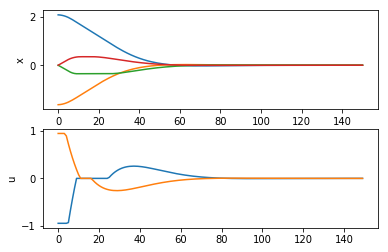

In [32]:
N_iter = 100

## solve OCP with dae_multiple_shooting method
def MPC_controller(x_current):
    n_state = 4
    n_control = 2
    x = MX.sym('x',4)
    u = K @ x
    
    # time herizon
    N = 50
    dt = env.dt
    epsilon = 5e-2

    # Input bounds for the optimization variables
    u_low = env.action_space.low + epsilon * np.ones(n_control)
    u_high =env.action_space.high - epsilon * np.ones(n_control)

    x_low = env.observation_space.low + epsilon * np.ones(n_state)
    x_high = env.observation_space.high - epsilon * np.ones(n_state)

    x1 = MX.sym('x1')
    x2 = MX.sym('x2')
    x3 = MX.sym('x3')
    x4 = MX.sym('x4')
    u1 = MX.sym('u1')
    u2 = MX.sym('u2')

    x = vertcat(x1, x2, x3, x4)
    u = vertcat(u1, u2)
    rhs = vertcat(3*x3, 3*x4, u1, u2)
    f = Function('f', [x, u], [rhs])


    xdot = vertcat(3*x3, 3*x4, u1, u2)
    L = x.T @ x + u.T@u
    dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
    opts = {'tf':dt}
    F = integrator('F', 'cvodes', dae, opts)


    obj = 0
    w = []      # variables x0, u0, x1, u1, x2........
    lbw = []
    ubw = []
    g = []      # constraints
    lbg = []
    ubg = []

    # Initial conditions
    x_init = x_current
    Xk = MX.sym('X0', 4)
    w.append(Xk)
    lbw += [x_init[0], x_init[1], x_init[2], x_init[3]]
    ubw += [x_init[0], x_init[1], x_init[2], x_init[3]]

    for k in range(N):
        # Local control
        Uk = MX.sym('U'+str(k), 2)
        w.append(Uk)
        lbw += [u_low[0], u_low[1]]
        ubw += [u_high[0], u_high[1]]

        Fk = F(x0=Xk, p=Uk)
        Xk_end = Fk['xf']
        obj = obj + Fk['qf']

        # "Lift" the variable
        Xk = MX.sym('X'+str(k+1), 4)
        w.append(Xk)
        lbw += [x_low[0], x_low[1], x_low[2], x_low[3]]
        ubw += [x_high[0], x_high[1], x_high[2], x_high[3]]

        g.append(Xk_end - Xk)
        lbg += [0., 0., 0., 0.]
        ubg += [0., 0., 0., 0.]

    # final constraint Vf and its bound 
    g += [Xk.T @ S @ Xk]  
    lbg += [0.]
    ubg += [c]

    # Create an NLP solver
    nlp_prob = {'f': obj, 'x': vertcat(*w), 'g': vertcat(*g)}
    opts = {'ipopt' : {'print_level' : 0}, 'print_time' : False, 'error_on_fail' : True}
    solver = nlpsol('solver', 'ipopt', nlp_prob, opts);
    sol = solver(x0=0., lbg=lbg, ubg=ubg, lbx=lbw, ubx=ubw)
    u1 = sol['x'][4::6]
    u2 = sol['x'][5::6]
    return np.array([u1[0], u2[0]])

x = env.reset()
X_traj = [x]
U_traj = []
print('Env Initialized\nNow Printing Control Input of Each Itrerations:')
for i in range(N_iter):
    u = MPC_controller(x)
    print(u)
    x,r,done,info = env.step(u)
    X_traj.append(x)
    U_traj.append(u)
    env.render()
    
    if done:
        # This stops the simulation when 
        # a constraint is violated
        print(info)
        print('u:',u)
        print('x:',x)
        break

env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
U_traj = np.array(U_traj)
fig,ax = plt.subplots(2,1)
ax[0].plot(X_traj)
ax[0].set_ylabel('x')
ax[1].plot(U_traj)
ax[1].set_ylabel('u')

